# Gradient & Climate Velocity Plots (Temperature)

## 1950s Temperature

In [1]:
import xgcm
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

In [2]:
import copy
import numba

In [3]:
%matplotlib inline

In [4]:
%reload_ext autoreload
%autoreload 2
from chazbpei2020.preprocessing import *

## Surface k01

In [5]:
# k01 temperature for ensemble average (preprocessed)
directory = '~/chazbpei2020/data/processed/Temp/'
filename = 'temp_k01_ensAvg_1950_2100.nc'
temp_path = directory+filename
ds = xr.open_dataset(temp_path)

## Grid calculations

In [6]:
# default behavior is to extrapolite grid position to the left
ds_full = xgcm.generate_grid_ds(ds, {'X':'xt_ocean', 'Y':'yt_ocean'})

In [7]:
# Create grid object (periodic along X-axis)
grid = xgcm.Grid(ds_full, periodic=['X'], 
                 coords={'X': {'center': 'xt_ocean', 'left': 'xt_ocean_left'},
                         'Y': {'center': 'yt_ocean', 'left': 'yt_ocean_left'},
                         'T': {'center': 'time'}})

In [8]:
# Compute cartesian distances
grid_calculations(grid, ds_full)

In [9]:
# Calculate the decadal mean temperature for the 1950s
# use groupby bins or xhistogram
ds_temp_annual = ds_full.temp.groupby('time.year').mean(dim='time', skipna=True)
ds_temp_mean = ds_temp_annual.sel(year=1950).copy()
for yr in range(1951,1960):
     ds_temp_mean += ds_temp_annual.sel(year=yr)
        
ds_temp_mean = ds_temp_mean/10

/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/xarray/core/common.py:671: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  return self._groupby_cls(
/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [10]:
# ds_temp_mean.plot()

## Zonal Gradient of k01 Mean Temperature (ºC / km)

In [11]:
# Compute zonal (along x-axis) gradient of k01 temperature
dtemp_dx = grid.diff(ds_temp_mean, 'X', boundary='fill', fill_value=np.nan) / (ds_full.dxg / 1000)
dtemp_dx = dtemp_dx.squeeze()

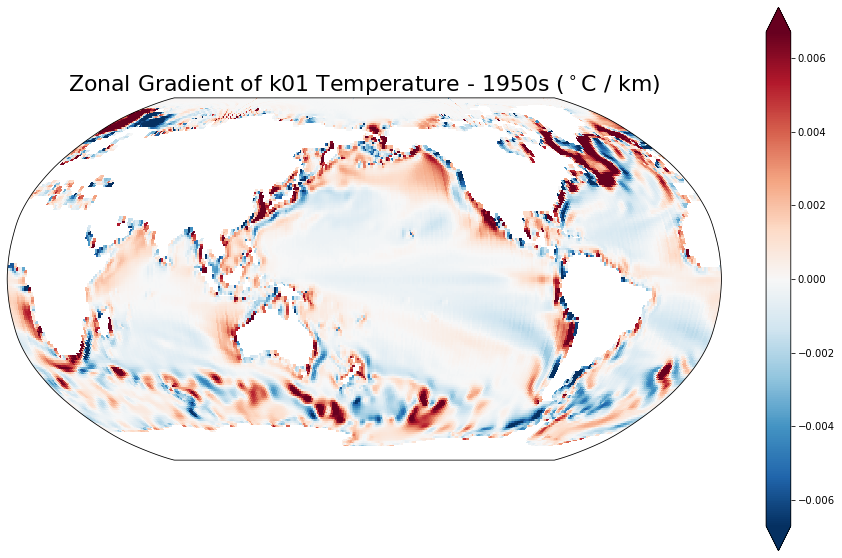

In [12]:
# Plot mean zonal Temperature gradient in 1950s
crs = ccrs.Robinson(central_longitude=180)
fig, ax = plt.subplots(figsize=[16,10],
                               subplot_kw={'projection':crs})

dtemp_dx.plot(ax=ax, transform=ccrs.PlateCarree(), robust=True)

ax.set_title('Zonal Gradient of k01 Temperature - 1950s ($^\circ$C / km)',
             fontsize=22)
ax.set_global() 
fig.savefig("temp_vel_plots")

## Meridional Gradient of k01 Temperature (ºC / km)

In [13]:
# Compute meridional (along y-axis) gradient of surface temperature
dtemp_dy = grid.diff(ds_temp_mean, 'Y', boundary='fill', fill_value=np.nan) / (ds_full.dyg / 1000)
dtemp_dy = dtemp_dy.squeeze()

In [14]:
# Flip direction in southern hemisphere so directions are poleward
dtemp_dy[0:90] = -dtemp_dy[0:90]

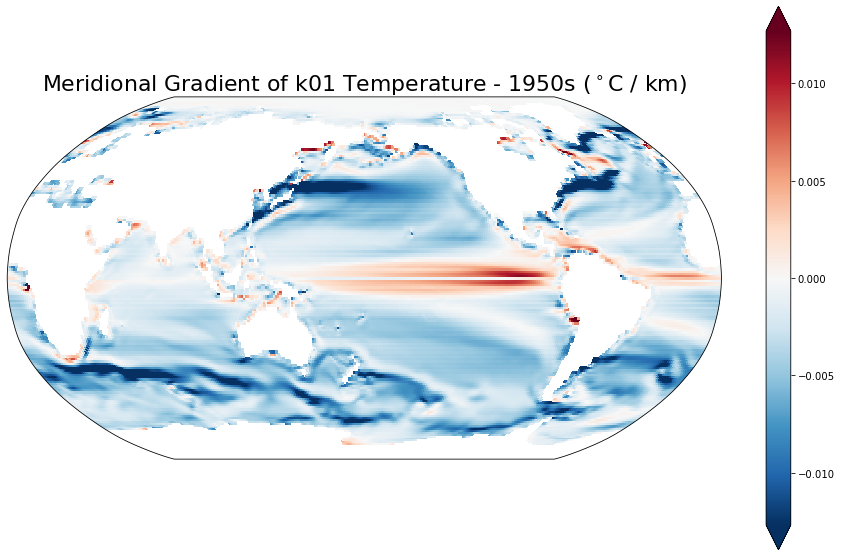

In [18]:
# Plot mean meridional Temperature gradient in 1950s
crs = ccrs.Robinson(central_longitude=180)
fig, ax = plt.subplots(figsize=[16,10],
                               subplot_kw={'projection':crs})

dtemp_dy.plot(ax=ax, transform=ccrs.PlateCarree(), robust=True)

ax.set_title('Meridional Gradient of k01 Temperature - 1950s ($^\circ$C / km)',
             fontsize=22)
ax.set_global()
fig.savefig("temp_vel_plots")

## Gradient Magnitude of k01 Temperature (ºC / km)

In [19]:
# Calculate magnitude of spatial gradient
dx2 = np.square(dtemp_dx).data
dy2 = np.square(dtemp_dy).data
dtemp_ds = np.sqrt(dx2+dy2)
# Create DataArray
lon = ds_full.xt_ocean.data
lat = ds_full.yt_ocean.data
dtemp_ds = xr.DataArray(dtemp_ds, dims=['yt_ocean','xt_ocean'], coords=[lat,lon])

In [20]:
# Create meshgrid for arrow plotting
X,Y = np.meshgrid(np.arange(360), np.arange(-90,90,1))
X = X+0.5
Y = Y+0.5
n=5

### Normalized Arrows

/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1841: RuntimeWarning: invalid value encountered in less
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1841: RuntimeWarning: invalid value encountered in greater
  u, v = self.projection.transform_vectors(t, x, y, u, v)


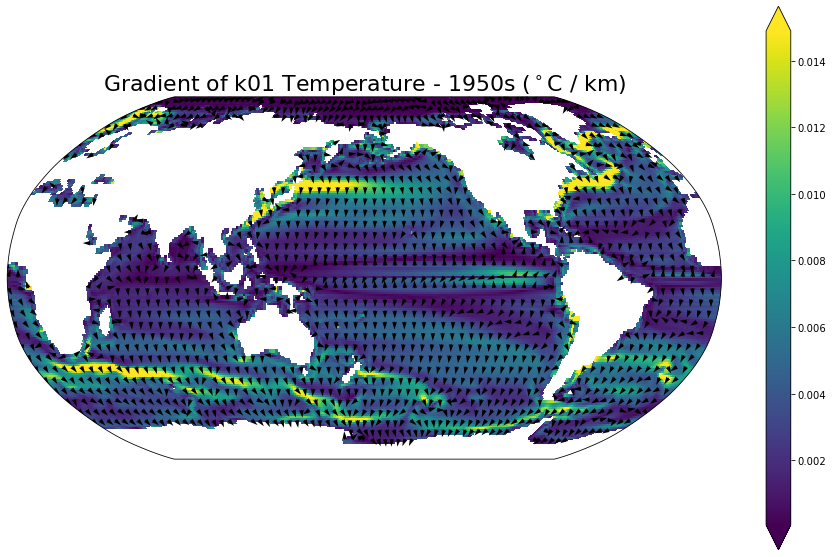

In [21]:
# Plot mean Temperature gradient in 1950s
crs = ccrs.Robinson(central_longitude=180)
fig, ax = plt.subplots(figsize=[16,10],
                               subplot_kw={'projection':crs})

src=ccrs.PlateCarree()
dtemp_ds.plot(ax=ax, transform=src, robust=True)

ax.set_title('Gradient of k01 Temperature - 1950s ($^\circ$C / km)',
             fontsize=22)

# Normalize vectors to plot arrows of constant size
U = dtemp_dx.data
V = dtemp_dy.data
N = np.sqrt(U**2 + V**2)
U = U/N
V = V/N

# Plot arrows to show gradient direction
ax.quiver(X[::n,::n], Y[::n,::n], U[::n,::n], V[::n,::n],
           transform=src)
ax.set_global()
fig.savefig("temp_vel_plots")

### Arrows with magnitude

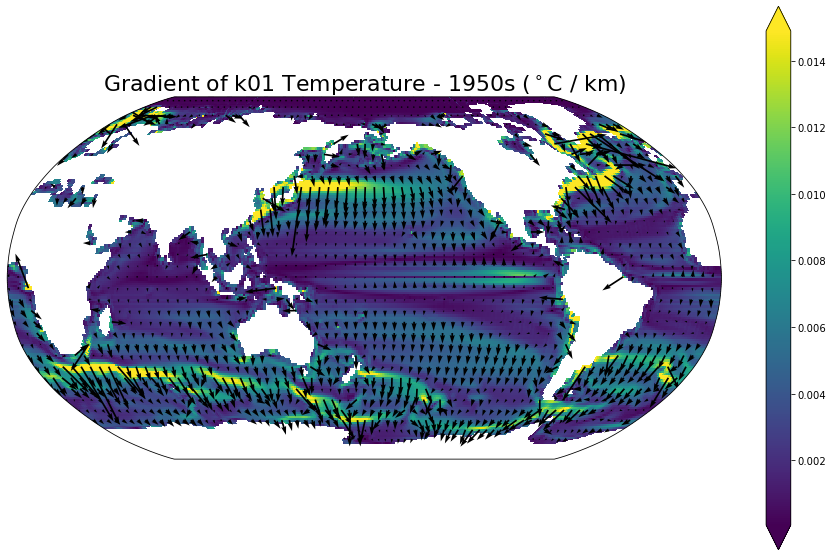

In [32]:
# Plot mean Temperature gradient in 1950s (contour plot)
crs = ccrs.Robinson(central_longitude=180)
fig, ax = plt.subplots(figsize=[16,10],
                               subplot_kw={'projection':crs})

src = ccrs.PlateCarree()
dtemp_ds.plot(ax=ax, transform=src, robust=True)

ax.set_title('Gradient of k01 Temperature - 1950s ($^\circ$C / km)',
             fontsize=22)

# Plot arrows to show gradient direction
ax.quiver(X[::n,::n],Y[::n,::n], 
           dtemp_dx.data[::n,::n],dtemp_dy.data[::n,::n],
           transform=src)

ax.set_global()
fig.savefig("temp_vel_plots")

### Contour Plot

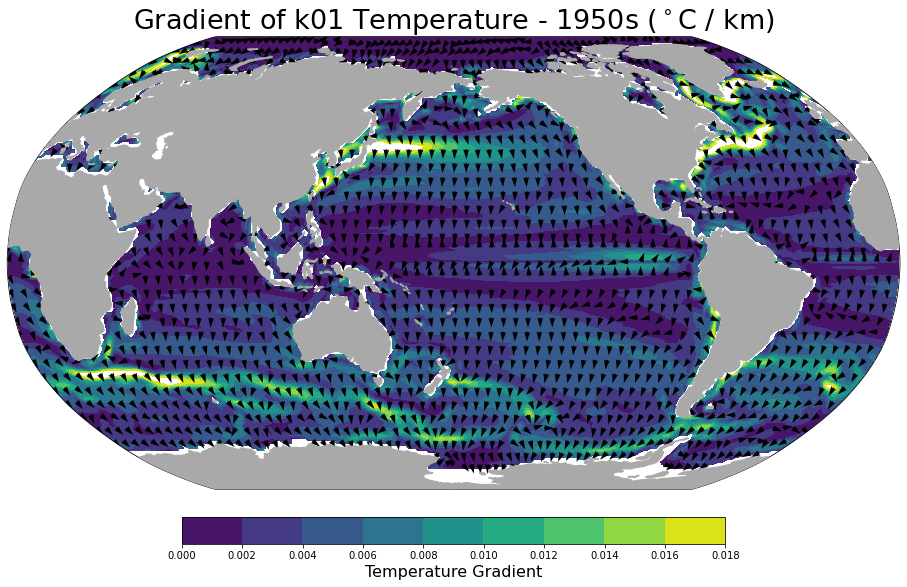

In [39]:
# Plot mean Temperature gradient in 1950s -- Contour Plot
crs = ccrs.Robinson(central_longitude=180)
fig, ax = plt.subplots(figsize=[16,10],
                               subplot_kw={'projection':crs})

src = ccrs.PlateCarree()
levels = np.arange(0,0.02,0.002)
im = ax.contourf(lon,lat,dtemp_ds,levels=levels, 
                 transform=src, robust=True)
cbar = plt.colorbar(im,ax=ax,orientation='horizontal',fraction=0.05,pad=0.05)
cbar.set_label('Temperature Gradient', fontsize=16)
ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')

ax.set_title('Gradient of k01 Temperature - 1950s ($^\circ$C / km)',
             fontsize=27)

# Normalize vectors to plot arrows of constant size
U = dtemp_dx.data
V = dtemp_dy.data
N = np.sqrt(U**2 + V**2)
U = U/N
V = V/N

# Plot arrows to show gradient direction
ax.quiver(X[::n,::n], Y[::n,::n], U[::n,::n], V[::n,::n],
           transform=src)

ax.set_global()
fig.savefig("temp_vel_plots")

## k01 Temperature Change

### Annual Temperature Change in 1950s

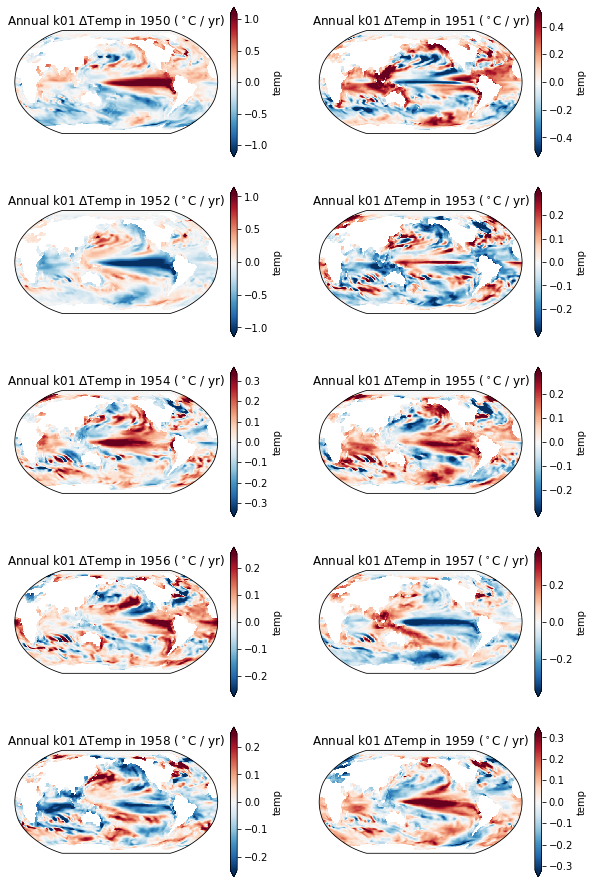

In [24]:
# Plot annual temperature change during 1950s
crs = ccrs.Robinson(central_longitude=180)
nrows = 5
ncols = 2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=[10,16],
                               subplot_kw={'projection':crs})

# Calculate dtemp/dt for each year
time0 = 1950
time1 = 1951
for row in range(0,nrows):
    for col in range(0,ncols):

        ax = axs[row,col]
        dtemp_dt = (ds_temp_annual.sel(year=time1) - ds_temp_annual.sel(year=time0))
        dtemp_dt.plot(ax=ax, transform=ccrs.PlateCarree(), robust=True)

        ax.set_title('Annual k01 $\Delta$Temp in '+str(time0)+' ($^\circ$C / yr)')
        ax.set_global()
        time0 += 1 # increment years
        time1 += 1
        
fig.savefig("temp_vel_plots")

### Decadal Temperature Change in 1950s (ºC / decade)

#### Using Linear Regression (best model)

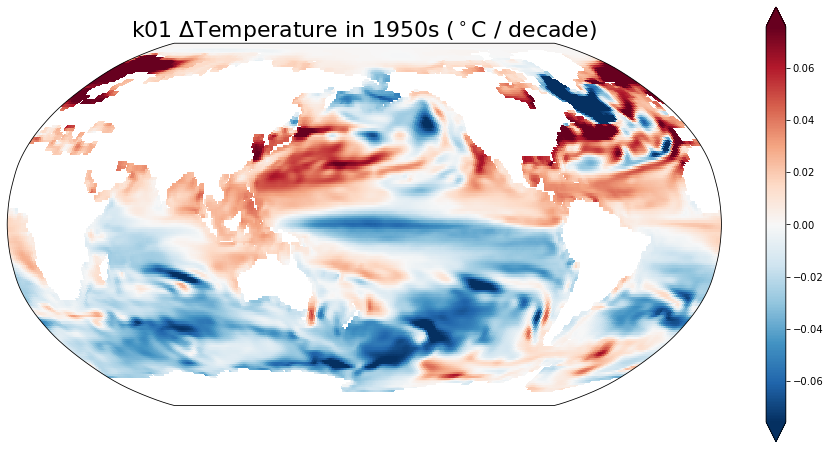

In [25]:
# Plot decadal temperature change using best-fit linear model
crs = ccrs.Robinson(central_longitude=180)
fig, ax = plt.subplots(figsize=[16,8],
                               subplot_kw={'projection':crs})

# Get annual temperature data for 1950s
ds_decade = ds_temp_annual.loc[1950:1959]

# Get lon, lat and time coordinates
lon = ds_decade.xt_ocean.data
lat = ds_decade.yt_ocean.data
years = ds_decade.year

# For each gridcell, obtain the linear regression for dtemp/dt
# using the annual means over the decade
nx = len(lon)
ny = len(lat)
da_bestfit = np.zeros(shape=(nx,ny))
for x in range(nx):
    for y in range(ny):
        # exclude NaN values
        cell = ds_decade.sel(xt_ocean=lon[x], yt_ocean=lat[y])
        idx = np.isfinite(cell).data.squeeze()
        yrs = years[idx].data.tolist()  # years with measured values
        pts = cell[idx].data.tolist()   # gridcells with measured values
        # calculate linear regression for temp (Y) vs. time (X)
        # (if there are at least 2 finite values)
        if sum(idx) > 1:
#             da_bestfit[x,y] = numba_leastsqr(yrs, pts)[0]
            da_bestfit[x,y] = np.polyfit(yrs, pts, 1)[0]
        else:
            da_bestfit[x,y] = np.nan
            
            
# Create DataArray and plot dtemp/dt for the decade
dtemp_dt = xr.DataArray(da_bestfit, dims=['xt_ocean','yt_ocean'], coords=[lon,lat])

levels = np.arange(-0.7,0.7,0.02)
dtemp_dt.T.plot(ax=ax, transform=ccrs.PlateCarree(), robust=True)
ax.set_title('k01 $\Delta$Temperature in 1950s ($^\circ$C / decade)',
            fontsize=22)
ax.set_global()
fig.savefig("temp_vel_plots")

#### Using Decadal Means (1950s and 1960s)

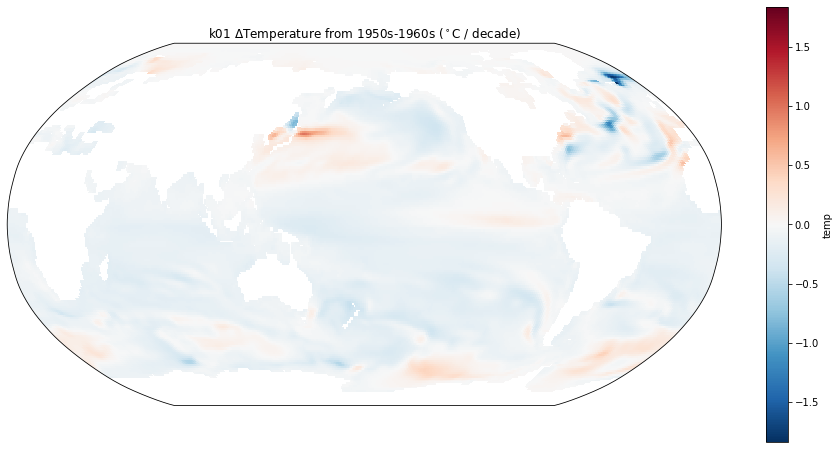

In [27]:
# Plot decadal temperature change using decadal means
crs = ccrs.Robinson(central_longitude=180)
fig, ax = plt.subplots(figsize=[16,8],
                               subplot_kw={'projection':crs})

ds_annual = ds_full.temp.groupby('time.year').mean(dim='time')

# Take decadal mean temperatures in 1950s and 1960s
dec0 = 1950
dec1 = 1960
ds_dec0 = ds_annual.sel(year=dec0).copy()
ds_dec1 = ds_annual.sel(year=dec1).copy()
for yr in range(1, 10):
    ds_dec0 += ds_annual.sel(year=dec0+yr)
    ds_dec1 += ds_annual.sel(year=dec1+yr)
        
ds_dec0 = ds_dec0/10
ds_dec1 = ds_dec1/10

# Plot dtemp/dt for the decade
dT_dt = (ds_dec1 - ds_dec0)
dT_dt.plot(ax=ax, transform=ccrs.PlateCarree(), robust=True)
ax.set_title('k01 $\Delta$Temperature from 1950s-1960s ($^\circ$C / decade)')
ax.set_global()

## Zonal k01 Temperature Velocity (km/decade)

<ipython-input-40-96a2a18edba1>:11: RuntimeWarning: divide by zero encountered in true_divide
  x_vel = dT_dt/dT_dx


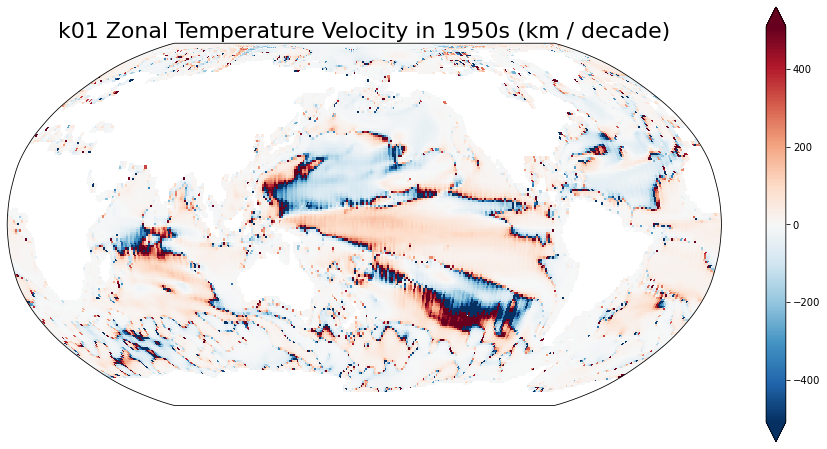

In [40]:
# Plot zonal temperature Velocity (km/decade) for 1950s
crs = ccrs.Robinson(central_longitude=180)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[16,8],
                               subplot_kw={'projection':crs})

# Using linear regression over decade for temperature change over time,
# and time-mean decadal temperature for spatial gradient
dT_dt = dtemp_dt.squeeze().data
dT_dx = dtemp_dx.squeeze().T.data

x_vel = dT_dt/dT_dx

# Create DataArray and plot temperature velocity
x_vel = xr.DataArray(x_vel, dims=['xt_ocean','yt_ocean'], coords=[lon,lat]).T
x_vel = x_vel.where(x_vel.loc[:,:] < np.inf)

x_vel.plot(ax=ax, transform=ccrs.PlateCarree(), robust=True)
ax.set_title('k01 Zonal Temperature Velocity in 1950s (km / decade)',
             fontsize=22)

fig.savefig("temp_vel_plots")

## Meridional Temperature Velocity (km/decade)

<ipython-input-41-d646b023490d>:11: RuntimeWarning: divide by zero encountered in true_divide
  y_vel = dT_dt/dT_dy


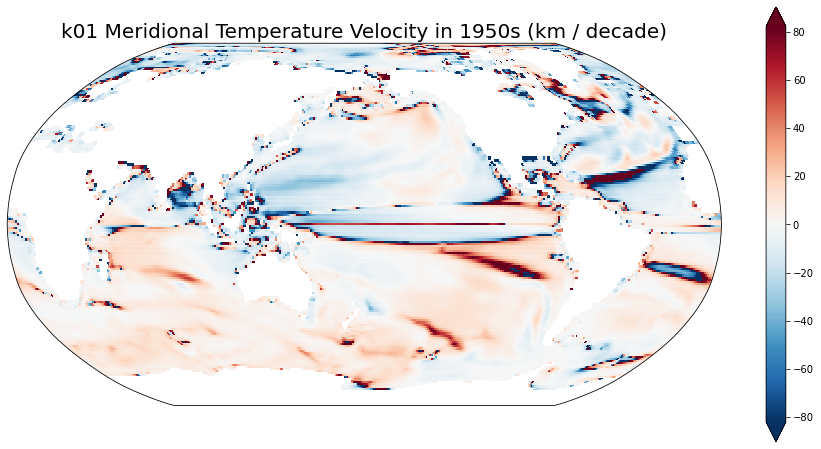

In [41]:
# Plot meridional temperature velocity (km/decade) for 1950s
crs = ccrs.Robinson(central_longitude=180)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[16,8],
                               subplot_kw={'projection':crs})

# Using linear regression over decade for temperature change over time,
# and time-mean decadal temperature for spatial gradient
dT_dt = dtemp_dt.squeeze().data
dT_dy = dtemp_dy.squeeze().T.data

y_vel = dT_dt/dT_dy

# Create DataArray and plot temperature velocity
y_vel = xr.DataArray(y_vel, dims=['xt_ocean','yt_ocean'], coords=[lon,lat]).T
y_vel = y_vel.where(y_vel.loc[:,:] != np.inf)

y_vel.plot(ax=ax, transform=ccrs.PlateCarree(), robust=True)
ax.set_title('k01 Meridional Temperature Velocity in 1950s (km / decade)',
             fontsize=20)

fig.savefig("temp_vel_plots")

## Temperature Velocity (km/decade)

In [29]:
# Calculate the magnitude for temperature velocity 
vx2 = np.square(x_vel).data
vy2 = np.square(y_vel).data
velocity = np.sqrt(vx2+vy2)
# Create DataArray
lon = ds_full.xt_ocean.data
lat = ds_full.yt_ocean.data

velocity = xr.DataArray(velocity, dims=['yt_ocean','xt_ocean'], coords=[lat,lon])
velocity = velocity.where(velocity.loc[:,:] != np.inf)

### Normalized Arrows

<ipython-input-30-9efaa2908050>:18: RuntimeWarning: invalid value encountered in true_divide
  U = U/N
/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1841: RuntimeWarning: invalid value encountered in less
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1841: RuntimeWarning: invalid value encountered in greater
  u, v = self.projection.transform_vectors(t, x, y, u, v)


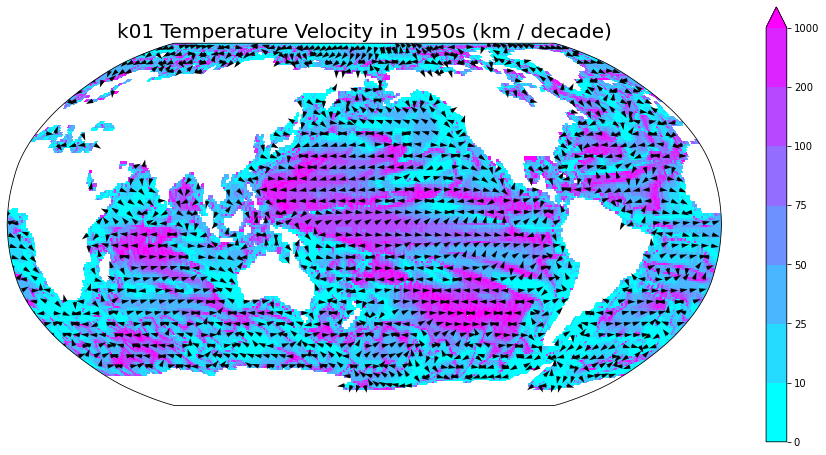

In [30]:
# Plot temperature velocity magnitude (km/decade) for 1950s
crs = ccrs.Robinson(central_longitude=180)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[16,8],
                               subplot_kw={'projection':crs})

# Create DataArray and plot temperature velocity
levels = [0,10,25,50,75,100,200,1000]
velocity.plot(ax=ax, levels=levels, cmap='cool',transform=ccrs.PlateCarree(), robust=True)
ax.set_title('k01 Temperature Velocity in 1950s (km / decade)',
             fontsize=20)

# Normalize vectors to plot arrows of constant size
U = x_vel.data
V = y_vel.data
N = np.sqrt(U**2 + V**2)
U = U/N
V = V/N
n=5

# Plot arrows to show gradient direction
ax.quiver(X[::n,::n], Y[::n,::n], U[::n,::n], V[::n,::n],
           transform=src)

fig.savefig("temp_vel_plots")

---